In [4]:
#################################################
################  Import things #################
#################################################

import numpy as np
import timeit
import random
import copy
import matplotlib.pyplot as plt
from sklearn import datasets
import pickle
from scipy import stats
import glycowork

from glycowork.glycan_data.loader import glycan_binding as gb
from glycowork.glycan_data.loader import glycomics_data_loader

In [5]:
# need to previously `run pip3 install esm`
import esm.pretrained
from glycowork.ml.inference import get_esm1b_representations, get_lectin_preds
from glycowork.ml.models import prep_model


model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S() # will need to download if the first time
leor = prep_model('LectinOracle', 1, trained = True)

In [6]:
prot_to_seq = gb.groupby('protein')['target'].first()
prot_seqs = gb['protein'].map(prot_to_seq).tolist()

# Check what characters are in your sequences
import string
def analyze_sequences(seqs):
    all_chars = set()
    valid_seqs = []
    invalid_seqs = []
    for i, seq in enumerate(seqs):

        if not isinstance(seq, str):
            print(f"Sequence {i} is not a string, it's a {type(seq)}: {seq}")
            invalid_seqs.append(i)
            continue
        
        chars = set(seq)
        all_chars.update(chars)
        # Check for any characters that aren't standard amino acids
        invalid_chars = chars - set('ABRNDCEQGHILKMFPSTWYVX')
        if invalid_chars:
            print(f"Sequence {i} has invalid characters: {invalid_chars}")
            print(f"Full sequence: {seq}")
            invalid_seqs.append(seq)
        else:
            valid_seqs.append(seq)  
    print("\nAll unique characters found:", sorted(all_chars))
    return invalid_seqs, valid_seqs

# Analyze your sequences
prot_to_seq = gb.groupby('protein')['target'].first()
prot_seqs = gb['protein'].map(prot_to_seq).tolist()
invalid_seqs, valid_seqs = analyze_sequences(prot_seqs)


Sequence 38 has invalid characters: {'-', '*'}
Full sequence: AEEAFDLWNECAKACVLDLKDGVRSSRMSVDPAIADTNGQGVLHYSMVLEGGNDALKLAIDNALSITSDGLTIRLEGGVEPNKPVRYSYTRQARGSWSLNWLVPIGHEKPSNIKVFIHELNAGNQLSHMSPIYTIEMGDELLAKLARDATFFVRAHESNEMQPTLAISHAGVSVVMAQAQPRREKRWSEWASGKVLCLLDPLDGVYNYLAQQRCNLDDTWEGKIYRVLAGNPAKHDLDIKPTVISHRLHFPEGGSLAALTAHQACHLPLETFTRHRQPRGWEQLEQCGYPVQRLVALYLAARLSWNQVDQVIRNALASPGSGGDLGEAIREQPEQARLALTLAAAESERFVRQGTGNDEAGAANADVVSLTCPVAAGECAGPADSGDALLERNYPTGAEFLGDGGDVSFSTRGTQNWTVERLLQAHRQLEERGYVFVGYHGTFLEAAQSIVFGGVRARSQDLDAIWRGFYIAGDPALAYGYAQDQEPDARGRIRNGALLRVYVPRSSLPGFYRTSLTLAAPEAAGEVERLIGHPLPLRLDAITGPEEEGGRL*TILGWPLAERTVVIPSAIPTDPRNVGGDLDPSSIPDKEQAISALPDYASQPGKPPREDLK-MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK
Sequence 703 is not a string, it's a <class 'float'>: nan
Sequence 865 has invalid ch

In [7]:
filename = '/Users/csfloyd/Library/CloudStorage/Dropbox/Projects/GlycanAnalysis/Data/LectinOracleReps_keep.pkl'
with open(filename, 'rb') as file:
    reps = pickle.load(file)


In [ ]:
df = glycomics_data_loader.human_skin_O_PMC5871710 # imports as a Pandas dataframe
glycans_in_df = list(df['glycan'])

gly_test = glycans_in_df[0]
pred_list = []
for i, prot_seq in enumerate(valid_seqs):
    try:
        pred = get_lectin_preds(prot_seq, [gly_test], leor, reps)
        pred_list.append(pred['pred'][0])
    except:
        print(prot_seq)
    if i%250 == 0:
        print(i)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460


(array([  3.,   5.,  21.,  75., 167., 395., 619., 155.,  21.,   1.]),
 array([-0.74779606, -0.63868392, -0.52957171, -0.42045957, -0.3113474 ,
        -0.20223522, -0.09312306,  0.01598911,  0.12510128,  0.23421344,
         0.34332561]),
 <BarContainer object of 10 artists>)

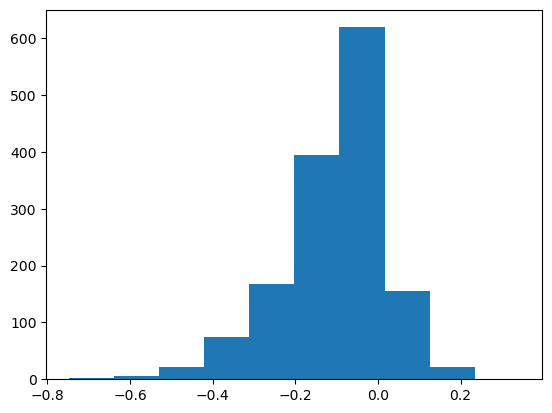

In [19]:
plt.hist(pred_list)

In [9]:
prot_seq_list = []
prot_seq_list.append(gb[gb['protein'] == "ConA"]['target'].iloc[0])
prot_seq_list.append(gb[gb['protein'] == "WGA"]['target'].iloc[0])

n_gly = len(glycans_in_df)
n_prots = len(prot_seq_list)
z_score_mat = np.zeros((n_prots, n_gly))

for (p, prot_seq) in enumerate(prot_seq_list):
    rep = get_esm1b_representations([prot_seq], model, alphabet)
    predictions = get_lectin_preds(prot_seq, glycans_in_df, leor, rep)
    z_scores = list([predictions['pred'][i] for i in range(len(predictions['pred']))])
    z_score_mat[p,:] = z_scores




NameError: name 'get_esm1b_representations' is not defined

In [7]:
from glycowork.glycan_data.loader import glycomics_data_loader
df = glycomics_data_loader.human_skin_O_PMC5871710 # imports as a Pandas dataframe
glycans_in_df = list(df['glycan'])

In [129]:
df.head()

,glycan,control_1,tumor_1,control_2,tumor_2,control_3,tumor_3,control_4,tumor_4,control_5,tumor_5,control_6,tumor_6,control_7,tumor_7,control_8,tumor_8,control_9,tumor_9
0,GalOS(b1-3)[Neu5Ac(a2-6)]GalNAc,2.755913,0.620301,3.019806,4.148615,2.413021,0.424605,1.764977,0.744528,4.518547,0.849240,3.174455,1.543922,3.752813,1.287601,1.574444,0.627539,4.415230,0.425039
1,Gal(b1-3)[Neu5Ac(a2-6)]GalNAc,0.775234,0.178490,0.778083,0.832907,0.824018,0.410873,0.617573,2.133773,0.603573,0.544599,1.317444,1.256997,0.860332,0.340373,0.927956,0.494144,1.045950,0.590404
2,Neu5Ac(a2-3)Gal(b1-3)GalNAc,9.219494,8.436141,16.190721,11.032313,16.061363,8.133529,12.291188,10.143781,10.865172,14.353894,12.313024,11.601938,13.246380,8.352032,12.352587,9.731834,16.170263,12.693331
3,Gal(b1-4)GlcNAc(b1-6)[Gal(b1-3)]GalNAc,2.770825,0.944913,1.531698,2.427562,1.570204,2.066165,2.832475,2.508954,2.228299,1.757840,4.811796,3.641077,1.437487,1.470697,2.324956,2.192553,0.805130,1.100490
4,Neu5Ac(a2-3)Gal(b1-3)[Neu5Ac(a2-6)]GalNAc,35.912676,30.058418,48.420833,43.738436,46.692847,26.728713,39.971128,32.290024,51.472292,40.669153,41.927351,37.755641,43.701528,32.565498,47.145757,38.565763,44.683562,33.532942


In [8]:
aff_mat = np.exp(0.2 * z_score_mat)
print(aff_mat)

def prob_dist(vals):
    return vals / np.sum(vals)

NameError: name 'z_score_mat' is not defined

In [137]:
group1_list = list(df.columns)[1:-1:2]
group2_list = list(df.columns)[2:-1:2]

activation1_array = np.zeros((len(group1_list), 2))
for (i, g) in enumerate(group1_list):
    glycan_dist = prob_dist(np.array(df[g]))
    activation1_array[i,:] = np.dot(aff_mat, glycan_dist)


activation2_array = np.zeros((len(group2_list), 2))
for (i, g) in enumerate(group2_list):
    glycan_dist = prob_dist(np.array(df[g]))
    activation2_array[i,:] = np.dot(aff_mat, glycan_dist)

In [126]:
activation2_array

array([[0.40275825, 0.77498617],
       [0.40424607, 0.74449065],
       [0.41015974, 0.81003685],
       [0.43099077, 0.7973172 ],
       [0.42538376, 0.72558546],
       [0.42550455, 0.80023557],
       [0.39551569, 0.78812702],
       [0.41845677, 0.73818347]])

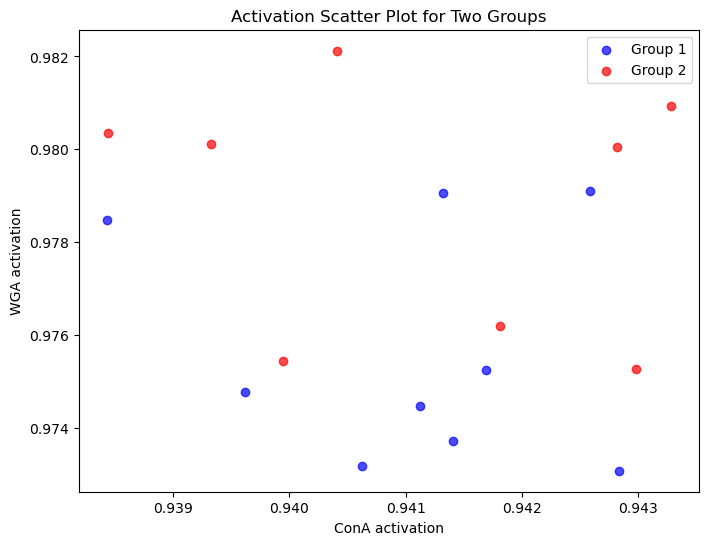

In [138]:
# Plot scatter plots for both groups
plt.figure(figsize=(8, 6))
plt.scatter(activation1_array[:,0], activation1_array[:,1], color='blue', label='Group 1', alpha=0.7)
plt.scatter(activation2_array[:,0], activation2_array[:,1], color='red', label='Group 2', alpha=0.7)

# Labels and legend
plt.xlabel('ConA activation')
plt.ylabel('WGA activation')
plt.title('Activation Scatter Plot for Two Groups')
plt.legend()
plt.show()